# 타이타닉 데이터 로드 및 분석에 활용할 라이브러리 임포트

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# 나이 그룹에 의한 생존율을 확인하는 것이 목적.
# 하지만 나이 컬럼에 177개 결측치가 확인
# 따라서 RandomForest model을 이용해 결측치를 처리

titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

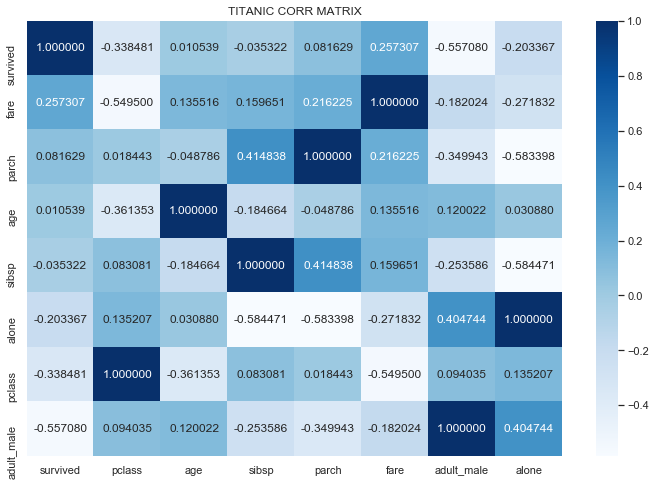

In [24]:
plt.figure(figsize=(12, 8))
plt.title("TITANIC CORR MATRIX")
sns.heatmap(titanic.corr().sort_values("survived", ascending=False) ,annot=True, fmt='f', cmap="Blues")
plt.show()

In [5]:
titanic['age'] = titanic["age"].fillna(0) # age컬럼의 결측치를 0으로 채움

# RandomForest를 통한 결측치 처리

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# RandomForest 모델을 이용해 age 컬럼의 결측치를 채운다.
# 이를 위해 0으로 채워진 데이터와 그렇지 않은 데이터를 분리시킨다.

titanic0 = titanic.loc[titanic['age'] == 0]
titanicNot0 = titanic.loc[titanic['age'] != 0]
print(titanic0.shape)
print(titanicNot0.shape)

rf = RandomForestClassifier()

# rf를 사용하기 위해 결측치로 인한 학습에 방해가 되는 컬럼 제거
titanicNot0 = titanicNot0.drop(["deck", "embark_town", "embarked"], axis=1)

# 범주형 데이터도 학습시키기 위해 원핫인코딩 진행
titanicNot0_dummies = pd.get_dummies(titanicNot0)

# titanic0 데이터에 who_child가 없기에 Not0 데이터 학습에서 제외
titanicNot0_dummies = titanicNot0_dummies.drop(["who_child"], axis=1)

# 전체 714 row중 오차지표 확인을 위해 600개 데이터 1차 학습
rf.fit(titanicNot0_dummies[:600], titanicNot0["age"][:600].astype("int"))

# rmse가 약 4정도로 양호한것을 확인
rf_prediction = rf.predict(titanicNot0_dummies[600:])
rf_mse = mean_squared_error(titanicNot0["age"][600:], rf_prediction)
rf_rmse = np.sqrt(rf_mse)
print(rf_rmse)

(177, 15)
(714, 15)
4.25814410607135


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


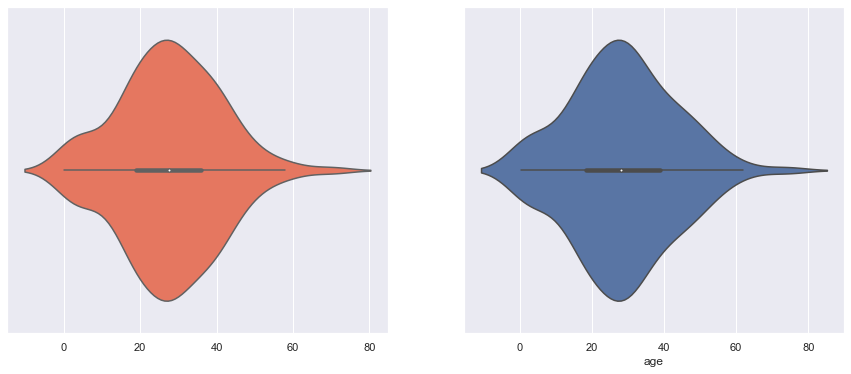

In [11]:
# violinplot을 이용해 예측데이터와 실제 데이터의 분포를 살펴보니 잘 예측이 된것으로 판단된다.
# 따라서 전체 데이터를 이용해 다시 모델을 학습시키고 실제 결측치에 대입하겠다.

plt.figure(figsize=(15,6))

# 예측데이터 violinplot
plt.subplot(121)
sns.violinplot(rf_prediction, palette="Reds")

# 실제데이터 violinplot
plt.subplot(122)
sns.violinplot(titanicNot0["age"][600:])

In [25]:
# 전체 데이터를 이용해 다시 모델을 학습시킵니다.

rf.fit(titanicNot0_dummies, titanicNot0["age"].astype("int"))

titanic0 = titanic0.drop(['deck','embarked','embark_town'], axis=1)

titanic0_dummies = pd.get_dummies(titanic0)

titanic0Values = rf.predict(X = titanic0_dummies)
titanic0Values

array([16, 19, 16, 17, 16, 16, 17, 16, 20, 16, 16, 16, 16, 16, 26, 16, 20,
       16, 16, 16, 16, 16, 16, 16, 19, 16, 16,  0, 18, 17, 17, 16, 16, 16,
       16, 16, 18, 16,  0, 16, 16, 16, 17, 16,  2, 18, 18,  0, 17, 16, 16,
       18, 16, 16, 16, 16, 16, 26, 16, 20, 17, 16, 16, 16,  0, 17, 16,  0,
       16, 17, 16, 16, 16, 16, 16, 17, 16, 16,  2, 16, 19, 16, 18, 16, 17,
       16,  0, 16, 16, 16, 17, 16, 16, 16, 16, 17, 16, 16,  2, 16, 16, 16,
       18, 26, 16, 16, 17, 17, 22, 17,  0, 16, 19, 16, 22, 16, 16, 18, 17,
       16, 18, 16, 16, 18, 19, 17, 16, 16, 17,  0, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 17, 16, 18, 16, 16, 20, 16, 16, 16, 16, 16, 16, 26,
       16, 16, 16, 17, 16, 16, 16, 16, 16, 16, 16, 17, 16, 16, 17, 16, 26,
       16, 17, 17, 16, 16, 16,  2])

In [26]:
# 결측치를 채우기 위한 새로운 데이터프레임 생성
predictAge0 = titanic0
predictAgeNot0 = titanicNot0

predictAge0["age"] = titanic0Values

data = predictAgeNot0.append(predictAge0)
data["age"] = data["age"].astype("int")

In [27]:
# 학습에 방해가 되었던 특성들을 다시 붙여 age특성만 결측치가 처리된 상태로 만듭니다.

data[["deck", "embark_town", "embarked"]] = titanic[["deck", "embark_town", "embarked"]]

In [28]:
data.isnull().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
class            0
who              0
adult_male       0
alive            0
alone            0
deck           688
embark_town      2
embarked         2
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


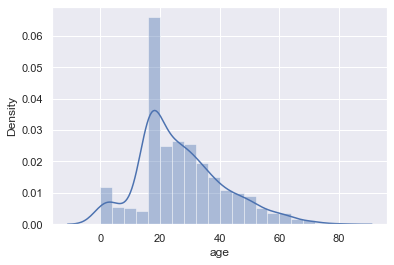

In [30]:
# 세개의 나이(age) 그룹을 만들기 위해 titanic데이터의 탑승자 연령 데이터를 히스토그램으로 확인합니다.
# 0세~80세의 구간을 가지며 10대 후반에서 40대 사이에 주로 분포한 것을 알 수 있습니다.

sns.distplot(data.age, bins=20)

In [36]:
# 확실한 최대, 최소 수치를 확인합니다.

print("최대값 : ",data.age.max())
print("최소값 : ",data.age.min())

최대값 :  80
최소값 :  0


In [32]:
# qcut 함수는 동일한 갯수를 기준으로 데이터를 분할하기 때문에 age 컬럼을 오름차순으로 정렬합니다.

titanic_sorted_by_age =  data.sort_values("age")
titanic_sorted_by_age

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,alive,alone,deck,embark_town,embarked
831,1,2,male,0,1,1,18.7500,Second,child,False,yes,False,NaN,Southampton,S
533,1,3,female,0,0,2,22.3583,Third,woman,False,yes,False,NaN,Cherbourg,C
78,1,2,male,0,0,2,29.0000,Second,child,False,yes,False,NaN,Southampton,S
431,1,3,female,0,1,0,16.1000,Third,woman,False,yes,False,NaN,Southampton,S
347,1,3,female,0,1,0,16.1000,Third,woman,False,yes,False,NaN,Southampton,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,1,male,70,1,1,71.0000,First,man,True,no,False,B,Southampton,S
96,0,1,male,71,0,0,34.6542,First,man,True,no,True,A,Cherbourg,C
493,0,1,male,71,0,0,49.5042,First,man,True,no,True,NaN,Cherbourg,C
851,0,3,male,74,0,0,7.7750,Third,man,True,no,True,NaN,Southampton,S


In [37]:
# qcut함수 사용을 위한 함수를 정의하고 age_class라는 새로운 범주를 생성합니다.

def q3cut(s):
    return pd.qcut(s, 3, labels = ["미성년자","청년층","중년층"]).astype(str) # qcut을 이용해 미성년자, 청년, 중년층 총 3개의 범주로 분할합니다.

titanic_sorted_by_age["age_class"] = titanic_sorted_by_age.age.transform(q3cut)
titanic_sorted_by_age.head()

,survived,pclass,sex,age,sibsp,parch,fare,class,who,adult_male,alive,alone,deck,embark_town,embarked,age_class
831,1,2,male,0,1,1,18.7500,Second,child,False,yes,False,NaN,Southampton,S,미성년자
533,1,3,female,0,0,2,22.3583,Third,woman,False,yes,False,NaN,Cherbourg,C,미성년자
78,1,2,male,0,0,2,29.0000,Second,child,False,yes,False,NaN,Southampton,S,미성년자
431,1,3,female,0,1,0,16.1000,Third,woman,False,yes,False,NaN,Southampton,S,미성년자
347,1,3,female,0,1,0,16.1000,Third,woman,False,yes,False,NaN,Southampton,S,미성년자


In [38]:
titanic_sorted_by_age["age_class"].unique() # qcut함수가 제대로 장동했는지 unique함수를 통해 age_class의 고유값을 확인합니다.

array(['미성년자', '청년층', '중년층'], dtype=object)

In [39]:
 # value_counts함수를 이용해 age_class 범주의 각 고유값에 몇개의 데이터가 포함되었는지 확인합니다.

titanic_sorted_by_age["age_class"].value_counts()

청년층     305
미성년자    300
중년층     286
Name: age_class, dtype: int64

In [40]:
# 각 age_class별로 제대로 나뉘어졌는지 그룹별 평균값으로 확인합니다.

titanic_sorted_by_age.age.groupby(titanic_sorted_by_age.age_class).mean()

age_class
미성년자    13.076667
중년층     43.706294
청년층     24.773770
Name: age, dtype: float64

In [41]:
len(titanic_sorted_by_age) # 전체 탑승자 수

891

In [42]:
# 성별, 선싱, 나이 그룹에 의한 생존률을 구하기 위해  해당그룹인원 / 전체탑승자 수로 계산합니다.

survival_rate = titanic_sorted_by_age.groupby(["sex","class","age_class"])["survived"].sum()/len(titanic_sorted_by_age)
survival_rate

sex     class   age_class
female  First   미성년자         0.021324
                중년층          0.052750
                청년층          0.028058
        Second  미성년자         0.016835
                중년층          0.029181
                청년층          0.032548
        Third   미성년자         0.051627
                중년층          0.005612
                청년층          0.023569
male    First   미성년자         0.004489
                중년층          0.029181
                청년층          0.016835
        Second  미성년자         0.010101
                중년층          0.004489
                청년층          0.004489
        Third   미성년자         0.017957
                중년층          0.008979
                청년층          0.025814
Name: survived, dtype: float64

In [43]:
final_df = pd.DataFrame(survival_rate)

final_df = final_df.fillna(0) # null값 0으로 치환

final_df["survive_rate(%)"] = final_df["survived"]*100 # 퍼센트로 바꾸기 위해

del final_df["survived"]

final_df

survive_rate(%)
sex    class  age_class                 
female First  미성년자              2.132435
              중년층               5.274972
              청년층               2.805836
       Second 미성년자              1.683502
              중년층               2.918070
              청년층               3.254770
       Third  미성년자              5.162738
              중년층               0.561167
              청년층               2.356902
male   First  미성년자              0.448934
              중년층               2.918070
              청년층               1.683502
       Second 미성년자              1.010101
              중년층               0.448934
              청년층               0.448934
       Third  미성년자              1.795735
              중년층               0.897868
              청년층               2.581369

In [44]:
final_df['survive_rate(%)'].sum()

38.38383838383838

In [50]:
final_df = final_df.reset_index()

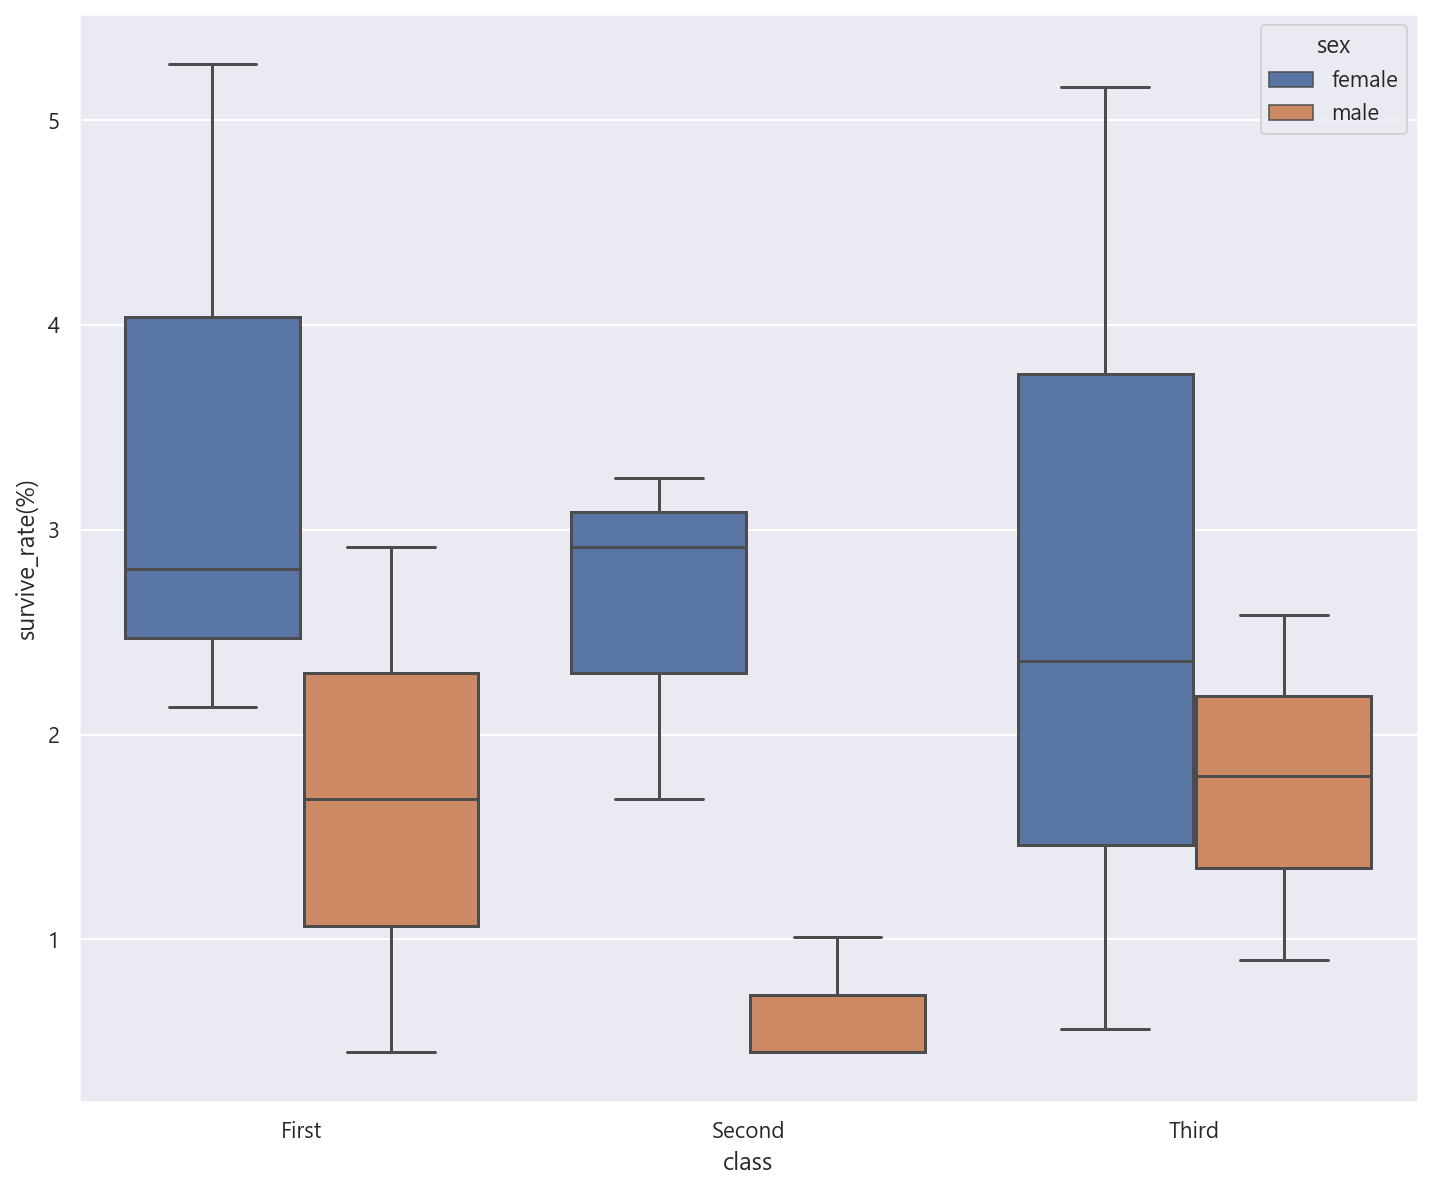

In [59]:
# 남녀를 기준으로 생존율을 시각화 한 결과 class가 모든 class에서 여성이 우선적으로 구출되었음을 알 수 있습니다.

plt.figure(figsize=(12, 10))
sns.boxplot(data=final_df, x="class", y="survive_rate(%)", hue="sex")

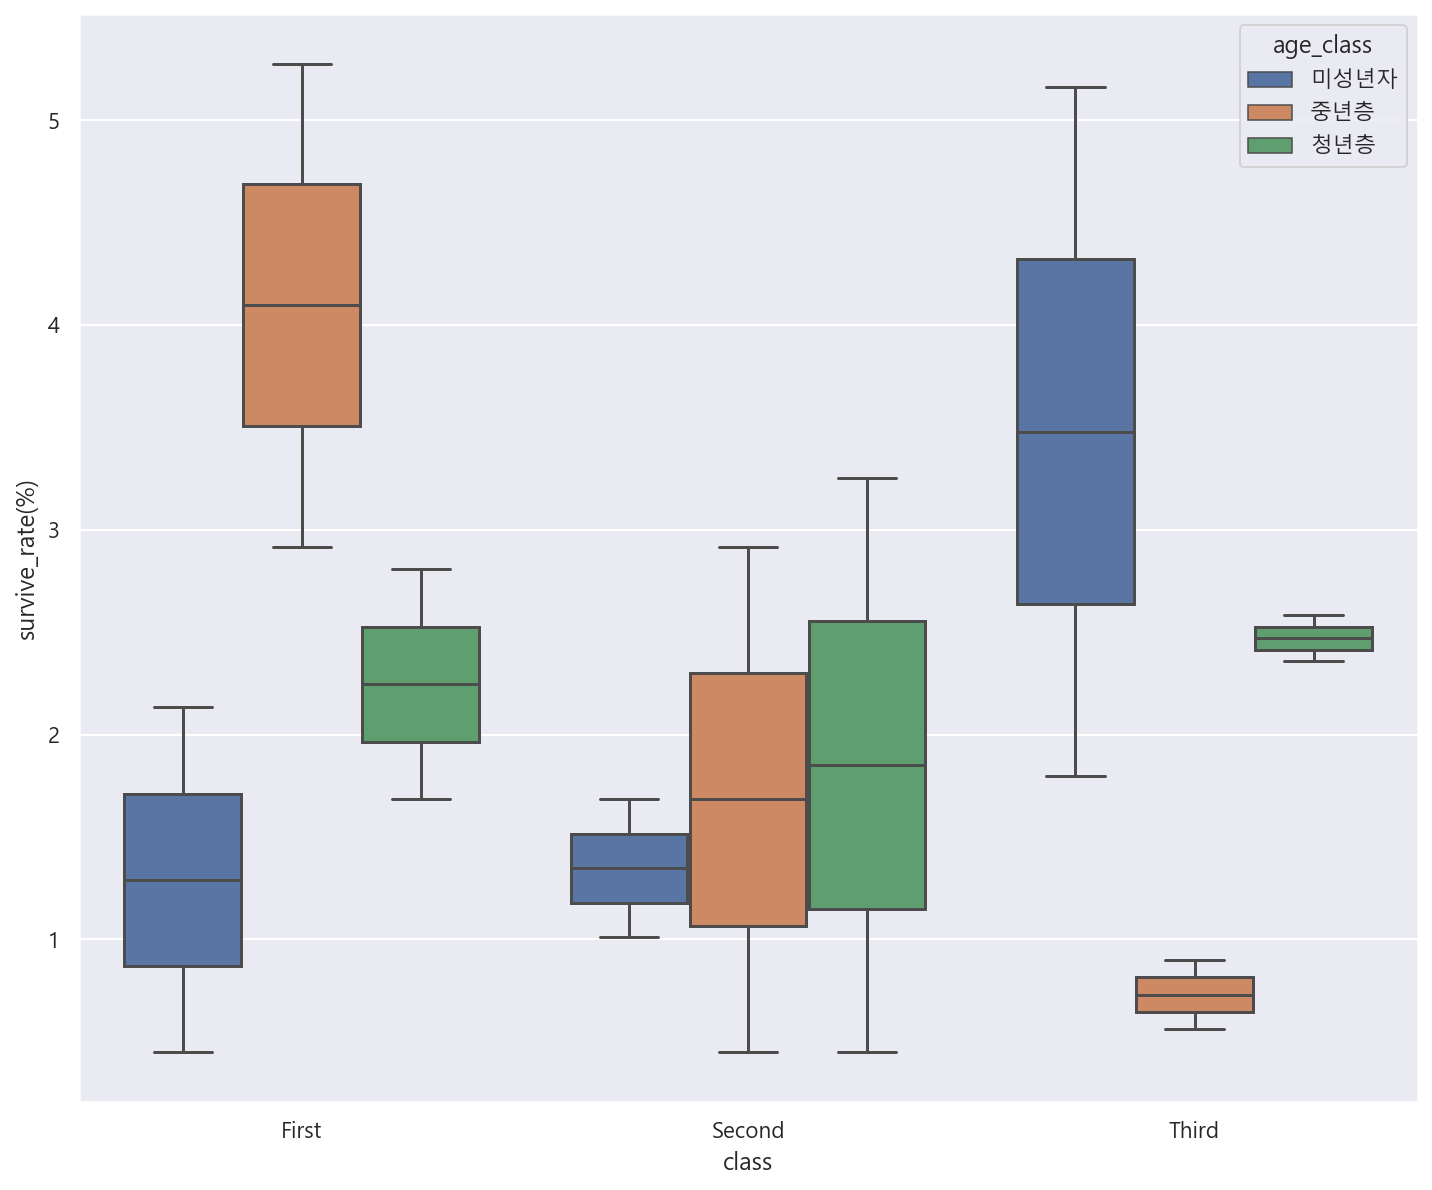

In [60]:
# 추가적으로 age_class를 기준으로 생존율을 분석한 결과 FIRST 클래스에서는 중년층이 우선적으로 구출되었으며 THIRD CLASS에서는 미성년자층이 우선적으로 구출되었음을 알 수 있습니다.

plt.figure(figsize=(12, 10))
sns.boxplot(data=final_df, x="class", y="survive_rate(%)", hue="age_class")